# Import all the important libraries.

In [2]:
!pip install xgboost

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
#get model duration
import time
from datetime import date

In [4]:
# use below script to see output of whole code.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_Interactivity = 'all'


# Read the dataset

In [5]:
insurance = pd.read_csv("insurance.csv")

In [6]:
insurance.shape

(1338, 7)

In [7]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
insurance.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [9]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Identify the missing values

In [10]:
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [11]:
total_miss = insurance.isnull().any()    # Looks like there are no missing values.
total_miss

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

# Feature Enginerring and EDA

In [12]:
insurance.corr()   # Checking correlation between the features.

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


<AxesSubplot:>

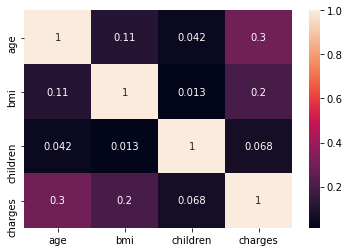

In [13]:
#heat map, smoking, age and bmi have a stronger relationship with charges
sns.heatmap(insurance.corr(), annot=True)

C:\Users\ashashiju\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ashashiju\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ashashiju\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for h

AttributeError: 'JointGrid' object has no attribute 'annotate'

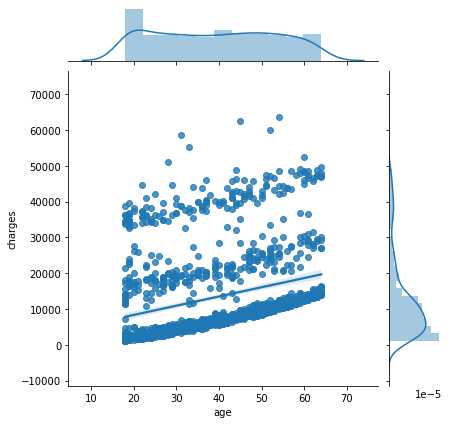

In [14]:
# From below plot, we can see that insurance charges are increasing with increase on age.

from scipy import stats
g = sns.JointGrid(insurance['age'],insurance['charges'])
g = g.plot(sns.regplot, sns.distplot)
g = g.annotate(stats.pearsonr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              1338 non-null   int64   
 1   sex              1338 non-null   object  
 2   bmi              1338 non-null   float64 
 3   children         1338 non-null   int64   
 4   smoker           1338 non-null   object  
 5   region           1338 non-null   object  
 6   charges          1338 non-null   float64 
 7   children_binned  764 non-null    category
dtypes: category(1), float64(2), int64(2), object(3)
memory usage: 74.7+ KB


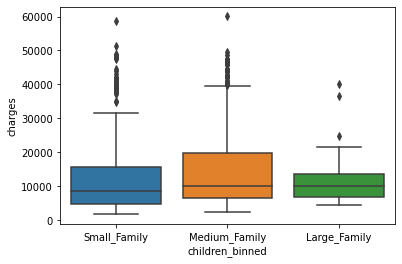

In [15]:
#binning, grouping # of children into family size
bins = [0,1,3,5]
labels = ['Small_Family','Medium_Family','Large_Family']
insurance['children_binned'] = pd.cut(insurance['children'], bins=bins, labels=labels)
sns.boxplot(x = 'children_binned',y='charges', data = insurance)

insurance.info()

# Encoding features ('sex', 'smoker', 'region') 

In [16]:
for col in ['sex', 'smoker', 'region']:
    print( col,':')
    print(insurance[col].value_counts())
    

sex :
male      676
female    662
Name: sex, dtype: int64
smoker :
no     1064
yes     274
Name: smoker, dtype: int64
region :
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


In [29]:
# label endcoding for the object datatypes
for col in ['sex', 'smoker', 'region']:
    if (insurance[col].dtype == 'object'):
        le = preprocessing.LabelEncoder()
        le = le.fit(insurance[col])
        insurance[col] = le.transform(insurance[col])
        print('Completed Label encoding on',col)

In [31]:
insurance= insurance.drop(['children_binned'],axis=1)

In [32]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [33]:
insurance.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002127,0.299008
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.004588,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.157566,0.198341
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.016569,0.067998
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.002181,0.787251
region,0.002127,0.004588,0.157566,0.016569,-0.002181,1.000000,-0.006208
charges,0.299008,0.057292,0.198341,0.067998,0.787251,-0.006208,1.000000


<AxesSubplot:>

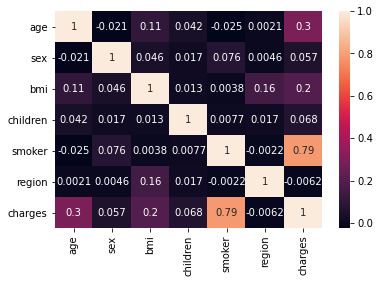

In [34]:
#heat map, smoking, age and bmi have a stronger relationship with charges
sns.heatmap(insurance.corr(), annot=True)

In [35]:
insurance.dtypes

age           int64
sex           int32
bmi         float64
children      int64
smoker        int32
region        int32
charges     float64
dtype: object

C:\Users\ashashiju\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


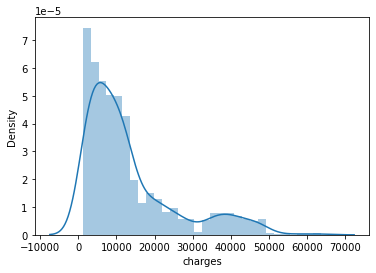

In [36]:
sns_plot = sns.distplot(insurance['charges'])

In [37]:
for col in ['sex', 'smoker', 'region']:
    print( col,':')
    print(insurance[col].value_counts())
    

sex :
1    676
0    662
Name: sex, dtype: int64
smoker :
0    1064
1     274
Name: smoker, dtype: int64
region :
2    364
1    325
3    325
0    324
Name: region, dtype: int64


# Hence we can encoded 'sex' feature as '0' for female & '1' for male.
# For 'smoker' feature, '0' for no & '1' for yes.
# For 'region' feature, '0' for northeast, '1' for southwest, '2' for southeast & '3' for northwest.

In [38]:
#sex :
#male      676    sex = 1 is male.
#female    662    sex = 0 is female.

#smoker :
#no     1064       smoker = 0 means no (not a smoker)
#yes     274       smoker = 1 means yes (a smoker)

#region :
#southeast    364          2 - southeast  
#northwest    325          3 - northwest
#southwest    325          1 - southwest 
#northeast    324          0 - northeast

In [39]:
# Saving cleaned and encoded dataset
insurance.to_csv('insurance_encoded.csv',index = False)

# Splitting independent and dependent variables

In [40]:
insurance_input = insurance.drop(['charges'],axis=1)
insurance_target = insurance['charges']

# Feature scaling


In [41]:
#stadardize data    
x_scaled = StandardScaler().fit_transform(insurance_input)

# Train/Test split

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled,
                                                    insurance_target,
                                                    test_size = 0.25,
                                                    random_state=1211)

# Build Models

# 1. Linear Regression

In [43]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

#instantiate
linReg = LinearRegression()

start_time = time.time()

# fit linear model to the train set data
linReg_model = linReg.fit(x_train, y_train)

today = date.today()
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.010950565338134766 seconds ---


In [44]:
linReg.coef_

array([3690.94980639, -154.24448937, 1926.27073861,  520.55396204,
       9697.07408404, -410.85583285])

In [45]:
#get coefficient values

input_columns = insurance.columns[:6] #get feature names

coeff_df = pd.DataFrame(linReg.coef_, input_columns, columns=['Coefficient'])  
coeff_df

,Coefficient
age,3690.949806
sex,-154.244489
bmi,1926.270739
children,520.553962
smoker,9697.074084
region,-410.855833


# From above, we can observe that features:  'smoker', 'age' and 'bmi' have  the highest effect on the insurance charges which is right because even in the real world - age, obesity and smoking habits have significant influences over health risks and thus higher insurance charges.

In [47]:
#validate model
y_pred_train = linReg.predict(x_train)    # Predict on train data.
y_pred_train[y_pred_train < 0] = y_pred_train.mean()
y_pred = linReg.predict(x_test)   # Predict on test data.
y_pred[y_pred < 0] = y_pred.mean()
diff = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
diff.head(5)

,Actual,Predicted
926,2913.56900,675.576998
490,1748.77400,2813.561034
1245,5615.36900,4312.605591
854,24106.91255,34277.985644
1002,1972.95000,1575.497282


# Plotting the actual and Predicted.

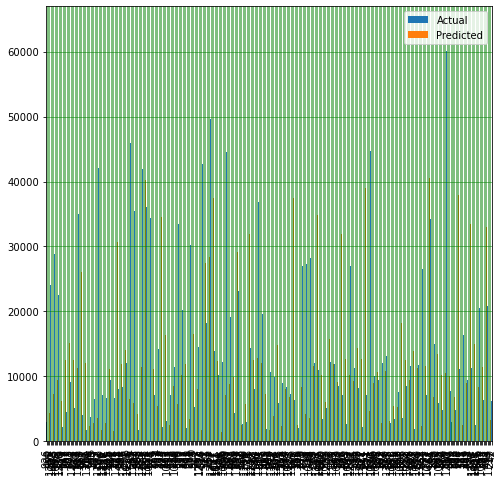

In [48]:
#Plotting the actual and Predicted.
diff.plot(kind='bar',figsize=(8,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [49]:
# Since above graph is not very clear, we will plot first 10 values.
diff1 = diff.head(10)
diff1

,Actual,Predicted
926,2913.56900,675.576998
490,1748.77400,2813.561034
1245,5615.36900,4312.605591
854,24106.91255,34277.985644
1002,1972.95000,1575.497282
448,5910.94400,7289.580969
475,28868.66390,37298.040845
1059,4462.72180,7388.135839
683,9863.47180,9473.012595
1278,22462.04375,32398.763860


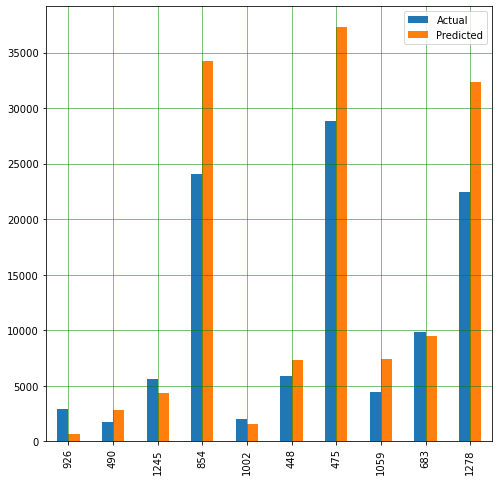

In [41]:
diff1.plot(kind='bar',figsize=(8,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [42]:
def calculate_accuracy(actual, predicted):
    SST = 0
    SSR = 0
    SSE = 0
    RMSE = 0
    VIF = 0
    RSqr = 0
    MAE = 0
    MAPE = 0
    SST = sum((actual - np.mean(predicted))**2)    # Calculate the SST
    SSR = sum((predicted - np.mean(predicted))**2) # Calculate the SSR
    SSE = sum((actual - predicted)**2)             # Calculate the SSE
    RMSE = np.sqrt((sum((predicted - actual)**2))/len(predicted))  # Calculate the RMSE
    RSqr = 1 - (SSE/SST)                           # Calcualte the R_square
    if RSqr != 1:
        VIF = 1 / (1 - RSqr)                           # Calculate the VIF
    #MAPE_house_price = mape(dtc_predict_train, y_train)           # Calculate the MAPE
    #MAE_house_price = mae(y_train, dtc_predict_train)             # Calculate the MAE
    return RMSE, RSqr, VIF


In [43]:
# Finding MAE, MSE and other, metrics.
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print the intercept and coefficients
print('Intercept: ',linReg.intercept_)
#print('r2 score: ',linReg.score(x_train, y_train))
#print('r2 score: ',linReg.score(x_test, y_test))

Mean Absolute Error: 4068.9236952525494
Mean Squared Error: 36334934.76430281
Root Mean Squared Error: 6027.8466108804405
Intercept:  13207.388159129547


In [44]:
# calculate the accuracies
RMSE, RSqr, VIF = calculate_accuracy(y_train,y_pred_train)
print('Linear RMSE train = ',RMSE, 'R-Square train = ',RSqr, 'VIF train = ',VIF)

RMSE, RSqr, VIF = calculate_accuracy(y_test,y_pred)
print('Linear RMSE test = ',RMSE, 'R-Square test = ',RSqr, 'VIF test = ',VIF)

Linear RMSE train =  6200.042303094936 R-Square train =  0.7437907235802793 VIF train =  3.903059303605406
Linear RMSE test =  6027.846610880443 R-Square test =  0.7328599025559048 VIF test =  3.743354178454141


In [46]:
#Backward elimination to check for high significance feature

import statsmodels.api as sm
a = 0
b = 0
a, b = insurance_input.shape
insurance_input = np.append(arr = np.ones((a, 1)).astype(int), values = insurance_input, axis = 1)
print (insurance_input.shape)

insurance_input_opt = insurance_input[:, [0, 1, 2, 4]]
##OrdinaryLeastSquares
regressorOLS = sm.OLS(endog = insurance_target, exog = insurance_input_opt).fit()
regressorOLS.summary()

(1338, 7)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     47.43
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           4.00e-29
Time:                        23:03:47   Log-Likelihood:                -14410.
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1334   BIC:                         2.885e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1837.2804   1022.425      1.797      0.073    -168.455    3843.016
x1           256.8610     22.458     11.437      0.000     212.804     300.918
x2          1515.1059    630.399      2.403      0.016     278.424    2751.788
x3           545.1609    261.732      2.083      0.037      31.709    1058.613
==============================================================================
Omnibus:                      397.122   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              856.804
Skew:                           1.721   Prob(JB):                    8.86e-187
Kurtosis:                       4.876   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
#Backward elimination to check for high significance feature

import statsmodels.api as sm
a = 0
b = 0
a, b = x_scaled.shape
x_scaled = np.append(arr = np.ones((a, 1)).astype(int), values = x_scaled, axis = 1)
print (x_scaled.shape)

x_scaled_opt = x_scaled[:, [0, 1, 2, 4]]
##OrdinaryLeastSquares
regressorOLS = sm.OLS(endog = insurance_target, exog = x_scaled_opt).fit()
regressorOLS.summary()

(1338, 7)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     47.43
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           4.00e-29
Time:                        23:03:35   Log-Likelihood:                -14410.
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1334   BIC:                         2.885e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.327e+04    315.062     42.120      0.000    1.27e+04    1.39e+04
x1          3607.5381    315.421     11.437      0.000    2988.764    4226.313
x2           757.5115    315.182      2.403      0.016     139.204    1375.819
x3           656.9418    315.398      2.083      0.037      38.211    1275.673
==============================================================================
Omnibus:                      397.122   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              856.804
Skew:                           1.721   Prob(JB):                    8.86e-187
Kurtosis:                       4.876   Cond. No.                         1.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 2. Decision Tree

In [47]:
from sklearn.tree import DecisionTreeRegressor
dtc = DecisionTreeRegressor(random_state=1)

# create the model
dtc.fit(x_train,y_train)

# prediction on train data
dtc_predict_train = dtc.predict(x_train)

# prediction on test data
dtc_predict_test = dtc.predict(x_test)

# calculate the accuracies
RMSE, RSqr, VIF = calculate_accuracy(y_train,dtc_predict_train)
print('Decision Tree RMSE train = ',RMSE, 'R-Square train = ',RSqr, 'VIF train = ',VIF)

RMSE, RSqr, VIF = calculate_accuracy(y_test,dtc_predict_test)
print('Decision Tree RMSE test = ',RMSE, 'R-Square test = ',RSqr, 'VIF test = ',VIF)

Decision Tree RMSE train =  279.1173376029252 R-Square train =  0.9994805465077318 VIF train =  1925.1001579244978
Decision Tree RMSE test =  6478.045105346515 R-Square test =  0.6914493037774626 VIF test =  3.240958494803608


In [48]:
from sklearn.ensemble import RandomForestRegressor
# Random forest model
rfc = RandomForestRegressor()

rfc.fit(x_train,y_train)

# prediction on train data
rfc_predict_train = rfc.predict(x_train)

# prediction on test data
rfc_predict_test = rfc.predict(x_test)

# calculate the accuracies
RMSE, RSqr, VIF = calculate_accuracy(y_train,rfc_predict_train)
print('Random Forest RMSE train = ',RMSE, 'R-Square train = ',RSqr, 'VIF train = ',VIF)

RMSE, RSqr, VIF = calculate_accuracy(y_test,rfc_predict_test)
print('Random Forest RMSE test = ',RMSE, 'R-Square test = ',RSqr, 'VIF test = ',VIF)

Random Forest RMSE train =  1831.1366515890613 R-Square train =  0.977645046409188 VIF train =  44.73281485187277
Random Forest RMSE test =  4868.187431693168 R-Square test =  0.8257596456341147 VIF test =  5.739198612395564


# Summarizing accuracy metrics of all the models

In [49]:
print('Metrics of linear regression:')
RMSE, RSqr, VIF = calculate_accuracy(y_train,y_pred_train)
print('Linear RMSE train = ',RMSE, 'R-Square train = ',RSqr, 'VIF train = ',VIF)
RMSE, RSqr, VIF = calculate_accuracy(y_test,y_pred)
print('Linear RMSE test = ',RMSE, 'R-Square test = ',RSqr, 'VIF test = ',VIF)
print('                                  ')

print('Metrics of Decision Tree:')
RMSE, RSqr, VIF = calculate_accuracy(y_train,dtc_predict_train)
print('Decision Tree RMSE train = ',RMSE, 'R-Square train = ',RSqr, 'VIF train = ',VIF)
RMSE, RSqr, VIF = calculate_accuracy(y_test,dtc_predict_test)
print('Decision Tree RMSE test = ',RMSE, 'R-Square test = ',RSqr, 'VIF test = ',VIF)
print('                                  ')

print('Metrics of Random Forest:')
RMSE, RSqr, VIF = calculate_accuracy(y_train,rfc_predict_train)
print('Random Forest RMSE train = ',RMSE, 'R-Square train = ',RSqr, 'VIF train = ',VIF)
RMSE, RSqr, VIF = calculate_accuracy(y_test,rfc_predict_test)
print('Random Forest RMSE test = ',RMSE, 'R-Square test = ',RSqr, 'VIF test = ',VIF)



Metrics of linear regression:
Linear RMSE train =  6200.042303094936 R-Square train =  0.7437907235802793 VIF train =  3.903059303605406
Linear RMSE test =  6027.846610880443 R-Square test =  0.7328599025559048 VIF test =  3.743354178454141
                                  
Metrics of Decision Tree:
Decision Tree RMSE train =  279.1173376029252 R-Square train =  0.9994805465077318 VIF train =  1925.1001579244978
Decision Tree RMSE test =  6478.045105346515 R-Square test =  0.6914493037774626 VIF test =  3.240958494803608
                                  
Metrics of Random Forest:
Random Forest RMSE train =  1831.1366515890613 R-Square train =  0.977645046409188 VIF train =  44.73281485187277
Random Forest RMSE test =  4868.187431693168 R-Square test =  0.8257596456341147 VIF test =  5.739198612395564


# Since random forest model is doing better in my dataset, I will use Random forest as the final model to deploy and to predict the insurance charges based on a person's attributes.

In [50]:
import pickle

In [51]:
# save the model to disk
filename = 'streamlit_insurance_predictcharges.pkl'
pickle.dump(rfc, open(filename, 'wb'))

In [52]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.8257498375644474


In [ ]:
# Now we will use another notebook named 'predict insurance charges' 
# to build the app to predict insurance charges using streamlit  and again save the notebook in 
# C folder with name 'streamlitpredictinsurancecharges'